# Mathematical model formulation using JijModeling and optimization with OpenJij
In this tutorial, we explain the process of formulating a mathematical model using JijModeling, converting the mathematical model to QUBO, and solving it with OpenJij.

First, install the required packages.
Install JijModeling, a module to easily build mathematical models, and jijmodeling-transpiler, a module for converting mathematical models using JijModeling to QUBO.
These can be installed using `pip`.

In [1]:
# !pip install jijmodeling
# !pip install jijmodeling-transpiler

In [2]:
import jijmodeling as jm
import numpy as np
import matplotlib.pyplot as plt

# Traveling Salesman Problem (TSP)
We discuss the traveling salesman problem (TSP) as an example of a constrained optimization problem.
Suppose a salesman travels once to each of the  cities to sell a product and then returns to the city he started from.
The problem is to find the route with the shortest distance to reduce the cost of travel.

### Constraints
In this problem, there are two constraints: a location constraint, which states that a salesman can only visit each point once, and a time constraint, which states that since there is only one salesman, he can only be in one city at a given time.

Using a binary variable with $x_{t,i}=1$ when visiting the $i$th city at time $t$ and $x_{t,i}=0$ otherwise, the above two constraints are:


$$\text{Location constraint : }\sum_{t=1}^N x_{t,i}=1 \quad \forall i$$

$$\text{Time constraint : }\sum_{i=1}^N x_{t,i}=1 \quad \forall t$$

These are one-hot constraints.

### Objective function
TSP is a problem of finding the shortest route.
Therefore, if $d_{ij}$ is the distance between points $i$ and $j$, the distance traveled when visiting city $i$ at time $t$ and city $j$ at time $t+1$ is:

$$d_{ij}x_{t,i}x_{t+1,j}$$

The sum of the above is:

$$\sum_{t=1}^N\sum_{i=1}^N \sum_{j=1}^N d_{ij}x_{t,i}x_{t+1,j}$$

This is the total distance traveled, which is the objective function we wish to minimize.

To perform Ising optimization as described in the previous tutorials, a mathematical model with such constraints must be converted to an Ising Hamiltonian or QUBO Hamiltonian.
Doing such work by hand is tedious and may introduce bugs between the actual mathematical model and QUBO.
JijModeling can do all this work automatically.
In other words, it can code the mathematical model constructed as described above and automatically convert it to QUBO.
In this section, we explain how to use JijModeling to solve TSP.

## Building a mathematical model of the TSP using JijModeling
First, we use JijModeling to describe the mathematical model of the problem.
Unlike ordinary modelers for mathematical optimization calculations, JijModeling builds the mathematical model independently from the data of the problem instance.
By constructing the mathematical model this way, the generality of the mathematical model can be ensured.
Moreover, mathematical equations can be described intuitively, just like writing mathematical equations on paper.
Furthermore, the mathematical model described in JijModeling can be checked in tex on the notebook.

In this section, we construct mathematical models one by one with JijModeling.

First, let us define the variables and the constants of the problem.

In [3]:
dist = jm.Placeholder("dist", dim=2)
N = jm.Placeholder("N")
x = jm.Binary("x", shape=(N, N))
i = jm.Element("i", (0,N))
j = jm.Element("j", (0,N))
t = jm.Element("t", (0,N))

Here, `jm.Placeholder` represents a constant, which is the distance matrix and the number of cities.
Various TSPs are represented by this distance matrix and the number of cities.

Binary variables are represented by `jm.Binary`.
Here we define a binary variable of $N\times N$.
Then, we use `jm.Element` to define the subscripts `i`,`j`,`t`.
These are used to represent the range of sums.

In JijModeling, we create a `jm.Problem` instance and add objective functions and constraints to it.
Next, we will define the objective function using the variables we have defined.

In [4]:
problem = jm.Problem("TSP")
obj = jm.Sum([t, i, j], dist[i, j] * x[t, i] * x[(t + 1) % N, j])
problem += obj
problem

The sum can be expressed with `jm.Sum`.
The first argument of `jm.Sum` is the indices to be summed, and since the objective function of TSP takes sums for three indices, we pass those indices (`jm.element`) in a list.

Then, we add the constraint conditions.

In [5]:
# Constraint 1 : one-hot position constraint
problem += jm.Constraint(
            "one-hot location",
            x[:, i] == 1,
            forall=[i,],
        )

# Constraint 2 : one-hot time constraint
problem += jm.Constraint(
            "one-hot time",
            x[t, :] == 1,
            forall=[t,],
        )

Constraints can be expressed using `jm.Constraint`.
The first argument is the name of the constraint condition, and the second argument is a mathematical expression of the constraint condition.

This constraint has an optional argument, `forall`.
This is a JijModeling argument that expresses what is expressed in a mathematical model as "for any $i$" or "$\forall i$".

Also, the notation `x[:,i]` that appears in the constraints is a sugar-coated syntax for writing `jm.Sum(t,x[t,i])`.

Finally, let us check the mathematical model we have just described.

In [6]:
problem

We see the same mathematical equations displayed as in the mathematical model used in the explanation.

This completes the construction of the mathematical model.
As above, JijModeling allows you to code mathematical models by comparing them with mathematical formulas.

## Creating the problem data
Now that we have a mathematical model of the problem, the next step is to create data for the problem.
Here we will solve a simple problem with 10 cities and random distances between cities.

(0.0, 1.0)

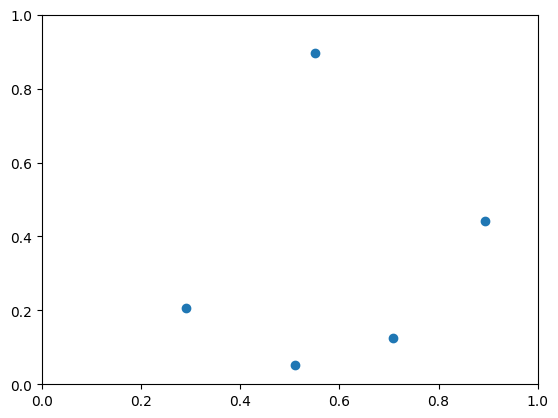

In [7]:
N = 5
np.random.seed(3)

x_pos = np.random.rand(N) 
y_pos = np.random.rand(N) 

plt.plot(x_pos, y_pos, 'o')
plt.xlim(0, 1)
plt.ylim(0, 1)

Since we assign the data to the `jm.Placeholder` to create the mathematical model, we need to pass the data in a dictionary type with the Placeholder's name as the key.
In this problem, we need to pass values for `N` and `dist`.

In [8]:
XX, XX_T = np.meshgrid(x_pos, x_pos)
YY, YY_T = np.meshgrid(y_pos, y_pos)
distance = np.sqrt((XX - XX_T)**2 + (YY - YY_T)**2)
instance_data = {
    "N":N,"dist": distance
}
instance_data

{'N': 5,
 'dist': array([[0.        , 0.7866063 , 0.73643374, 0.84577089, 0.56967619],
        [0.7866063 , 0.        , 0.4251585 , 0.21078131, 0.36540009],
        [0.73643374, 0.4251585 , 0.        , 0.26950348, 0.64576184],
        [0.84577089, 0.21078131, 0.26950348, 0.        , 0.54552992],
        [0.56967619, 0.36540009, 0.64576184, 0.54552992, 0.        ]])}

## Convert mathematical models to QUBO using JijModeling-Transpiler
Now that the mathematical model and data are ready, we convert the mathematical model and data to QUBO using JijModeling-Transpiler.

First, import `to_pyqubo`, a function to convert to QUBO.

In [9]:
from jijmodeling.transpiler.pyqubo import to_pyqubo

We create a pyqubo object by giving this `to_pyqubo` a mathematical model and the data of the problem.
Note that, if we want to fix some of the variables to a certain value, we can give them as the third variable in a dictionary type.

In [10]:
model,cache = to_pyqubo(problem,instance_data,{})

To generate QUBO, we pass the magnitude of the coefficients of the constraints to the pyqubo object  and then use the `to_qubo` method.

In [11]:
multipliers = {"one-hot location":1.0,"one-hot time":1.0}
Q,offset = model.compile().to_qubo(feed_dict = multipliers)

We have successfully generated QUBO.

# Performing optimization using OpenJij
Since QUBO has been obtained, optimization calculations can be performed as before using this QUBO.

In [12]:
import openjij as oj

In [13]:
sampler = oj.SASampler(num_reads=1)
res = sampler.sample_qubo(Q=Q)

The JijModeling-Transpiler function will format the results obtained by optimization into a more readable form.
Let us use the `decode` function.

In [14]:
result = cache.decode(res)
result

SampleSet(record=Record(solution={'x': [(([1, 0, 2, 3, 4], [0, 4, 2, 3, 1]), [1, 1, 1, 1, 1], ())]}, num_occurrences=[1]), evaluation=Evaluation(energy=[-7.848205186671934], objective=[2.151794813328065], constraint_violations={'one-hot location': [0.0], 'one-hot time': [0.0]}, penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, postprocess=None), system=SystemTime(post_problem_and_instance_data=None, request_queue=None, fetch_problem_and_instance_data=None, fetch_result=None, deserialize_solution=None), total=None))

The obtained solution is contained in the `solution` which is in the `result.record` as a sparse matrix.
The first two elements are critical: the first is the index in the matrix, and the second is the value of that index.
In the case of a binary variable, only the value that is 1 is stored, so the value usually contains only 1.

In [15]:
sparse_index,value,_ = result.record.solution['x'][0]
sparse_index

([1, 0, 2, 3, 4], [0, 4, 2, 3, 1])

In `result.evaluation`, there is energy, objective function, and constraint violation.
These represent the evaluation values obtained by optimization.
Here, we check whether the solution satisfies the constraints.

In [16]:
result.evaluation.constraint_violations

{'one-hot location': [0.0], 'one-hot time': [0.0]}

This shows that we have obtained a solution that satisfies the constraints.

Let us visualize this solution.
When plotting the route, we can get the order in which to move around the cities by sorting the city indices using the time-related indices.

In [17]:
time_indices, city_indices = zip(*sorted(zip(*sparse_index)))
time_indices, city_indices

((0, 1, 2, 3, 4), (4, 0, 2, 3, 1))

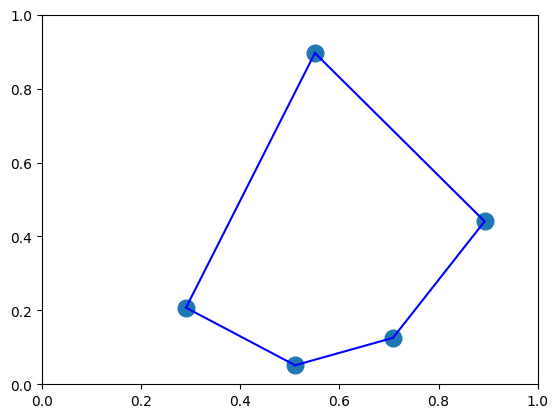

In [18]:
plt.plot(x_pos, y_pos, 'o',markersize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)

for i, city_index in enumerate(city_indices[:-1]):
    next_city_index = city_indices[i+1]
    plt.plot([x_pos[city_index],x_pos[next_city_index ]],[y_pos[city_index],y_pos[next_city_index ]],c = "blue")
    
plt.plot([x_pos[city_indices[-1]],x_pos[city_indices[0]]],[y_pos[city_indices[-1]],y_pos[city_indices[0]]],c = "blue")